In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['imet-2019-fgvc6', 'inceptionresnetv2']


In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps, ImageFilter
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 256
NUM_CLASSES = 1103
beta_f2=2
gamma = 1.0
checkpoint_file = '../working/resnet50_focal.h5'

Using TensorFlow backend.


In [3]:
# Load dataset info
path_to_train = '../input/imet-2019-fgvc6/train/'
data = pd.read_csv('../input/imet-2019-fgvc6/train.csv')

train_dataset_info = []
for name, labels in zip(data['id'], data['attribute_ids'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

## Focal Loss and F2 score provided by competition organizer

In [4]:
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

def f2(y_true, y_pred):
    #y_pred = K.round(y_pred)
#     y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), F2_THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + K.epsilon())
    f2 = tf.where(tf.is_nan(f2), tf.zeros_like(f2), f2)
    return K.mean(f2)

## Data preprocessing

### Resize weird images
**Pad narrow images(with aspect ratio < 0.5)**

In [5]:
def resize_weird_images(img, SIZE):
    aspect_ratio = img.size[0] / img.size[1]
    if aspect_ratio < 0.5:
        w_resized = int(img.size[0] * SIZE / img.size[1])
        resized = img.resize((w_resized ,SIZE))
        pad_width = SIZE - w_resized
        padding = (pad_width // 2, 0, pad_width-(pad_width//2), 0)
        img = ImageOps.expand(resized, padding, fill="white")
    elif aspect_ratio > 2:
        h_resized = int(img.size[1] * SIZE / img.size[0])
        resized = img.resize((SIZE, h_resized))
        pad_height = SIZE - h_resized
        padding = (0, pad_height // 2, 0, pad_height-(pad_height//2))
        img = ImageOps.expand(resized, padding, fill="white")
    
    return img

### Data generator
**load and create data for training and validing**

In [6]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

class data_generator(Sequence):
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), NUM_CLASSES))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                    
                yield np.array(batch_images, np.float32), batch_labels

    def create_valid(dataset_info, batch_size, shape, augument=False):
        assert shape[2] == 3
        while True:
            # dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), NUM_CLASSES))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels


    def load_image(path, shape):
        image = PIL.Image.open(path+'.png')
        image = resize_weird_images(image, SIZE)
        image = np.array(image)
        image = cv2.resize(image, (SIZE, SIZE))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            sometimes(
            iaa.OneOf([
                # iaa.AddToHueAndSaturation((-20, 20)),
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.Multiply((0.9, 1.1), per_channel=0.5),
                # iaa.GaussianBlur((0, 0.5)), # blur images with a sigma between 0 and 3.0
                iaa.ContrastNormalization((0.8, 1.2), per_channel=0.5), # improve or worsen the contrast
                iaa.Sharpen(alpha=(0, 0.2), lightness=(0.8, 1.2)), # sharpen images
                iaa.Emboss(alpha=(0, 0.5), strength=(0, 0.5)), # emboss images
                # iaa.Crop(percent=(0, 0.1))
                ])
            ),
            iaa.OneOf([
#                 iaa.Affine(rotate=0),
#                 iaa.Affine(rotate=90),
#                 iaa.Affine(rotate=180),
#                 iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                # iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Multiply, Flatten, Dense, Add, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
                          BatchNormalization, Input, Conv2D, Lambda, Concatenate)
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape

## Build Model

**Set parameters**

In [8]:
LR = 1e-4
LR_FACTOR = 0.45
LR_WARM = 1e-3
LR_MAX=1e-3
N_DATA_POINT=8000
EPOCHS=16
BATCH_SIZE=64

### Create Callback list to store checkpoint and parameters

In [9]:
from keras.callbacks import Callback

def get_1cycle_schedule(lr_max=LR_MAX, n_data_points=N_DATA_POINT, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0):          
    if verbose > 0:
        print("Setting up 1Cycle LR schedule...")
    pct_start, div_factor = 0.3, 25.        # @sgugger's parameters in fastai code
    lr_start = lr_max/div_factor
    lr_end = lr_start/1e4
    n_iter = (n_data_points * epochs // batch_size) + 1    # number of iterations
    a1 = int(n_iter * pct_start)
    a2 = n_iter - a1

    # make look-up table
    lrs_first = np.linspace(lr_start, lr_max, a1)            # linear growth
    lrs_second = (lr_max-lr_end)*(1+np.cos(np.linspace(0,np.pi,a2)))/2 + lr_end  # cosine annealing
    lrs = np.concatenate((lrs_first, lrs_second))
    return lrs

class OneCycleScheduler(Callback):
    def __init__(self, **kwargs):
        super(OneCycleScheduler, self).__init__()
        self.verbose = kwargs.get('verbose', 0)
        self.lrs = get_1cycle_schedule(**kwargs)
        self.iteration = 0

    def on_batch_begin(self, batch, logs=None):
        lr = self.lrs[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)         # here's where the assignment takes place
        if self.verbose > 0:
            print('\nIteration %06d: OneCycleScheduler setting learning '
                  'rate to %s.' % (self.iteration, lr))
        self.iteration += 1

    def on_epoch_end(self, epoch, logs=None):  # this is unchanged from Keras LearningRateScheduler
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        self.iteration = 0

In [10]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
from sklearn.model_selection import train_test_split

epochs = EPOCHS
batch_size = BATCH_SIZE

checkpoint = ModelCheckpoint('../working/Resnet50_focal.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)


# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
train_generator_warmup = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=False)
validation_generator = data_generator.create_valid(
    train_dataset_info[valid_indexes], batch_size, (SIZE,SIZE,3), augument=False)


lrsched = OneCycleScheduler(lr_max=1e-4, n_data_points=len(train_indexes),
        epochs=1, batch_size=batch_size, verbose=0)
# callbacks_list = [checkpoint, csv_logger, lrsched]
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]

In [11]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
   
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

### Create attention layers

In [12]:
import keras.backend as K
from keras.initializers import glorot_uniform

def res_conv(X, filters, base, s):
    
    name_base = base + '/branch'
    
    F1, F2, F3 = filters

    ##### Branch1 is the main path and Branch2 is the shortcut path #####
    
    X_shortcut = X
    
    ##### Branch1 #####
    # First component of Branch1 
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_1')(X)
    X= Activation('relu', name=name_base + '1/relu_1')(X)
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)

    # Second component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_2')(X)
    X = Activation('relu', name=name_base + '1/relu_2')(X)
    X = Conv2D(filters=F2, kernel_size=(3,3), strides=(s,s), padding='same', name=name_base + '1/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Third component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_3')(X)
    X = Activation('relu', name=name_base + '1/relu_3')(X)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_3', kernel_initializer=glorot_uniform(seed=0))(X)
    
    ##### Branch2 ####
    X_shortcut = BatchNormalization(axis=-1, name=name_base + '2/bn_1')(X_shortcut)
    X_shortcut= Activation('relu', name=name_base + '2/relu_1')(X_shortcut)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', name=name_base + '2/conv_1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    
    # Final step: Add Branch1 and Branch2
    X = Add(name=base + '/Add')([X, X_shortcut])

    return X

def res_identity(X, filters, base):
    
    name_base = base + '/branch'
    
    F1, F2, F3 = filters

    ##### Branch1 is the main path and Branch2 is the shortcut path #####
    
    X_shortcut = X
    
    ##### Branch1 #####
    # First component of Branch1 
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_1')(X)
    Shortcut= Activation('relu', name=name_base + '1/relu_1')(X)
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_1', kernel_initializer=glorot_uniform(seed=0))(Shortcut)

    # Second component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_2')(X)
    X = Activation('relu', name=name_base + '1/relu_2')(X)
    X = Conv2D(filters=F2, kernel_size=(3,3), strides=(1,1), padding='same', name=name_base + '1/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Third component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_3')(X)
    X = Activation('relu', name=name_base + '1/relu_3')(X)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_3', kernel_initializer=glorot_uniform(seed=0))(X)    
    
    # Final step: Add Branch1 and the original Input itself
    X = Add(name=base + '/Add')([X, X_shortcut])

    return X

def Trunk_block(X, F, base):
    
    name_base = base
    
    X = res_identity(X, F, name_base + '/Residual_id_1')
    X = res_identity(X, F, name_base + '/Residual_id_2')
    return X

def interpolation(input_tensor, ref_tensor,name): # resizes input_tensor wrt. ref_tensor
    H, W = ref_tensor.get_shape()[1], ref_tensor.get_shape()[2]
    return tf.image.resize_nearest_neighbor(input_tensor, [H.value, W.value],name=name)

def Attention_1(X, filters, base):    
    F1, F2, F3 = filters    
    name_base = base 
    
    X = res_identity(X, filters, name_base+ '/Pre_Residual_id')    
    X_Trunk = Trunk_block(X, filters, name_base+ '/Trunk')    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_3')(X)    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_3_Down')    
    Residual_id_3_Down_shortcut = X    
    Residual_id_3_Down_branched = res_identity(X, filters, name_base+ '/Mask/Residual_id_3_Down_branched')    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_2')(X)    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Down')    
    Residual_id_2_Down_shortcut = X    
    Residual_id_2_Down_branched = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Down_branched')    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_1')(X)    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Down')    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Up')    
    temp_name1 = name_base+ "/Mask/Interpool_1" 
    X = Lambda(interpolation, arguments={'ref_tensor': Residual_id_2_Down_shortcut,'name':temp_name1})(X)                                          
    X = Add(name=base + '/Mask/Add_after_Interpool_1')([X, Residual_id_2_Down_branched])                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Up')    
    temp_name2 = name_base+ "/Mask/Interpool_2"   
    X = Lambda(interpolation, arguments={'ref_tensor': Residual_id_3_Down_shortcut,'name':temp_name2})(X)                                          
    X = Add(name=base + '/Mask/Add_after_Interpool_2')([X, Residual_id_3_Down_branched])                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_3_Up')   
    temp_name3 = name_base+ "/Mask/Interpool_3"   
    X = Lambda(interpolation, arguments={'ref_tensor': X_Trunk,'name':temp_name3})(X)                                          
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_3/bn_1')(X)                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_3/relu_1')(X)                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_3/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)    
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_3/bn_2')(X)                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_3/relu_2')(X)                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_3/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)    
    X = Activation('sigmoid', name=name_base+'/Mask/sigmoid')(X)      
    X = Multiply(name=name_base+'/Mutiply')([X_Trunk,X])    
    X = Add(name=name_base+'/Add')([X_Trunk,X])
    X = res_identity(X, filters, name_base+ '/Post_Residual_id')    
    return X

def Attention_2(X, filters, base):    
    F1, F2, F3 = filters   
    name_base = base  
    
    X = res_identity(X, filters, name_base+ '/Pre_Residual_id')    
    X_Trunk = Trunk_block(X, filters, name_base+ '/Trunk')    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_2')(X)    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Down')    
    Residual_id_2_Down_shortcut = X    
    Residual_id_2_Down_branched = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Down_branched')    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_1')(X)    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Down')                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Up')    
    temp_name1 = name_base+ "/Mask/Interpool_1"    
    X = Lambda(interpolation, arguments={'ref_tensor': Residual_id_2_Down_shortcut,'name':temp_name1})(X)                                          
    X = Add(name=base + '/Mask/Add_after_Interpool_1')([X, Residual_id_2_Down_branched])                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_2_Up')    
    temp_name2 = name_base+ "/Mask/Interpool_2"    
    X = Lambda(interpolation, arguments={'ref_tensor': X_Trunk,'name':temp_name2})(X)                                          
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_2/bn_1')(X)                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_2/relu_1')(X)                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_2/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)    
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_2/bn_2')(X)                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_2/relu_2')(X)                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_2/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)    
    X = Activation('sigmoid', name=name_base+'/Mask/sigmoid')(X)      
    X = Multiply(name=name_base+'/Mutiply')([X_Trunk,X])    
    X = Add(name=name_base+'/Add')([X_Trunk,X])
    X = res_identity(X, filters, name_base+ '/Post_Residual_id')    
    return X

def Attention_3(X, filters, base):    
    F1, F2, F3 = filters    
    name_base = base    
    
    X = res_identity(X, filters, name_base+ '/Pre_Residual_id')    
    X_Trunk = Trunk_block(X, filters, name_base+ '/Trunk')    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name=name_base+ '/Mask/pool_1')(X)    
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Down')                                          
    X = res_identity(X, filters, name_base+ '/Mask/Residual_id_1_Up')    
    temp_name2 = name_base+ "/Mask/Interpool_1"    
    X = Lambda(interpolation, arguments={'ref_tensor': X_Trunk,'name':temp_name2})(X)                                          
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_2/bn_1')(X)                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_2/relu_1')(X)                                          
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_2/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)    
    X = BatchNormalization(axis=-1, name=name_base + '/Mask/Interpool_2/bn_2')(X)                                          
    X = Activation('relu', name=name_base + '/Mask/Interpool_2/relu_2')(X)                                         
    X = Conv2D(F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '/Mask/Interpool_2/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)    
    X = Activation('sigmoid', name=name_base+'/Mask/sigmoid')(X)      
    X = Multiply(name=name_base+'/Mutiply')([X_Trunk,X])    
    X = Add(name=name_base+'/Add')([X_Trunk,X])
    X = res_identity(X, filters, name_base+ '/Post_Residual_id')  
    return X

### Create attention model
**We created 3 attention layers. However in our experiments, model with 1 attention layer had the best performance**

In [13]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionResNetV2(include_top=False,
                 weights=None,
                 input_tensor=input_tensor)

    base_model.load_weights('../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
    for layer in base_model.layers:
        layer.trainable = False
    
    X = Conv2D(64, (7,7), strides=(2,2), padding='same', name='conv_1', kernel_initializer=glorot_uniform(seed=0))(base_model.output)
    X = BatchNormalization(axis=-1, name='bn_1')(X)
    X = Activation('relu', name='relu_1')(X)
    X = MaxPooling2D((3,3), strides=(2,2), padding='same' ,name='pool_1')(X)
    X = res_conv(X, [64,64,256], 'Residual_conv_1', 1)

    ### Attention 1 Start
    X = Attention_1(X, [64,64,256], 'Attention_1')
    ### Attention 1 End

#     X = res_conv(X, [128,128,512], 'Residual_conv_2', 2)

#     ### Attention 2 Start
#     X = Attention_2(X, [128,128,512], 'Attention_2')
#     ### Attention 2 End

#     X = res_conv(X, [256,256,1024], 'Residual_conv_3', 2)

#     ### Attention 3 Start
#     X = Attention_3(X, [256,256,1024], 'Attention_3')
#     ### Attention 3 End

    X = res_conv(X, [512,512,2048], 'Residual_conv_4', 2)

    X = res_identity(X, [512,512,2048], 'Residual_id_1')
    X = res_identity(X, [512,512,2048], 'Residual_id_2')
    X = BatchNormalization(axis=-1, name='bn_2')(X)
    X = Activation('relu', name='relu_2')(X)
    X = GlobalAveragePooling2D()(X)
    X = Dense(NUM_CLASSES, name='Dense_1')(X)
    X = Activation('sigmoid', name='classifier')(X)

    model = Model(inputs=input_tensor, outputs=X, name='ResnetV2_final')
    
    return model

**Create model and train new layers for 2 epochs**

In [14]:
# warm up model
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES)

# for layer in model.layers:
#     layer.trainable = False

for i in range(-201,0):
    model.layers[i].trainable = True

model.compile(loss='binary_crossentropy',
              metrics=['acc',f2],
    optimizer=Adam(LR_WARM))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
_____________________________________

block8_3_mixed (Concatenate)    (None, 6, 6, 448)    0           activation_172[0][0]             
                                                                 activation_175[0][0]             
__________________________________________________________________________________________________
block8_3_conv (Conv2D)          (None, 6, 6, 2080)   933920      block8_3_mixed[0][0]             
__________________________________________________________________________________________________
block8_3 (Lambda)               (None, 6, 6, 2080)   0           block8_2_ac[0][0]                
                                                                 block8_3_conv[0][0]              
__________________________________________________________________________________________________
block8_3_ac (Activation)        (None, 6, 6, 2080)   0           block8_3[0][0]                   
__________________________________________________________________________________________________
conv2d_177

In [15]:
model.fit_generator(
    train_generator_warmup,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    epochs=2,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
1451/1451 [==============================] - 900s 620ms/step - loss: 0.0142 - acc: 0.9967 - f2: 0.0077
Epoch 2/2
1451/1451 [==============================] - 865s 596ms/step - loss: 0.0120 - acc: 0.9972 - f2: 0.0100


In [16]:
print(K.eval(model.optimizer.lr))

0.001


**Train all layers**

In [17]:
for layer in model.layers:
    layer.trainable = True

model.compile(# loss='binary_crossentropy',
            loss=focal_loss,
            optimizer=Adam(lr=LR),
            metrics=['acc',f2])

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=EPOCHS,
    verbose=1,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    callbacks=callbacks_list)

Epoch 1/14
1451/1451 [==============================] - 1732s 1s/step - loss: 6.4942 - acc: 0.1664 - f2: 0.0150 - val_loss: 6.3593 - val_acc: 0.1915 - val_f2: 0.0171

Epoch 00001: val_loss improved from inf to 6.35933, saving model to ../working/Resnet50_focal.h5
Epoch 2/14
1451/1451 [==============================] - 1647s 1s/step - loss: 5.8846 - acc: 0.1966 - f2: 0.0182 - val_loss: 9.4294 - val_acc: 0.1943 - val_f2: 0.0177

Epoch 00002: val_loss did not improve from 6.35933
Epoch 3/14
1451/1451 [==============================] - 1646s 1s/step - loss: 5.7060 - acc: 0.2147 - f2: 0.0194 - val_loss: 5.8586 - val_acc: 0.2220 - val_f2: 0.0206

Epoch 00003: val_loss improved from 6.35933 to 5.85858, saving model to ../working/Resnet50_focal.h5
Epoch 4/14
1451/1451 [==============================] - 1727s 1s/step - loss: 5.4764 - acc: 0.2333 - f2: 0.0211 - val_loss: 5.6933 - val_acc: 0.2544 - val_f2: 0.0219

Epoch 00004: val_loss improved from 5.85858 to 5.69333, saving model to ../working/

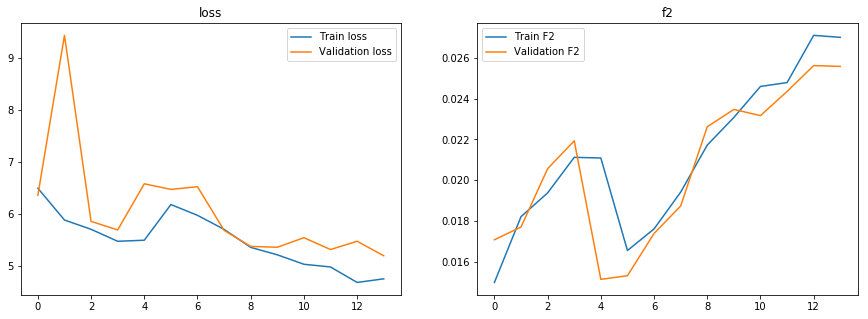

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('f2')
ax[1].plot(hist.epoch, hist.history["f2"], label="Train F2")
ax[1].plot(hist.epoch, hist.history["val_f2"], label="Validation F2")
ax[0].legend()
ax[1].legend()

**Our model is **

In [19]:
print(K.eval(model.optimizer.lr))

1e-04


**Search for the best threshold regarding the validation set**

In [21]:


BATCH = 512
fullValGen = data_generator.create_valid(
    train_dataset_info[valid_indexes], BATCH, (SIZE,SIZE,3))

n_val = round(train_dataset_info.shape[0]*0.2)//BATCH
print(n_val)

lastFullValPred = np.empty((0, NUM_CLASSES))
lastFullValLabels = np.empty((0, NUM_CLASSES))
for i in tqdm(range(n_val+1)): 
    im, lbl = next(fullValGen)
    scores = model.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

  0%|          | 0/43 [00:00<?, ?it/s]

42


100%|██████████| 43/43 [05:03<00:00,  6.76s/it]

(21506, 1103) (21506, 1103)


In [22]:
def my_f2(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + 1e-15)

    return f2

def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in tqdm(thrs):
        score.append(my_f2(targs, (preds > thr).astype(int) ))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


thr=0.230 F2=0.506


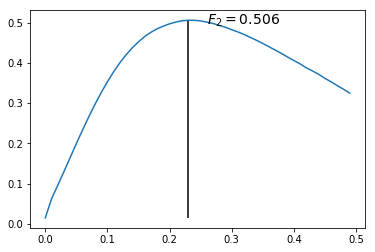

In [23]:
best_thr, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

In [ ]:
submit = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')
predicted = []

for i, name in tqdm(enumerate(submit['id'])):
    path = os.path.join('../input/imet-2019-fgvc6/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))
    score_predict = model.predict(preprocess_input(image[np.newaxis]))
    # print(score_predict)
    label_predict = np.arange(NUM_CLASSES)[score_predict[0]>=best_thr]
    # print(label_predict)
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

237it [00:15, 15.79it/s]

In [ ]:
submit['attribute_ids'] = predicted
submit.to_csv('submission.csv', index=False)